In [1]:
import pandas as pd
import numpy as np

### Import Data

In [2]:
data = pd.read_excel('Data_Train--Delivery.xlsx',usecols = [0,1,2,3,4,5,6,7])

### EDA & Preprocessing

In [3]:
data.head()

,Restaurant,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12,4,30
1,ID_2882,"Ice Cream, Desserts",100,50,3.5,11,4,30
2,ID_1595,"Italian, Street Food, Fast Food",150,50,3.6,99,30,65
3,ID_5929,"Mughlai, North Indian, Chinese",250,99,3.7,176,95,30
4,ID_6123,"Cafe, Beverages",200,99,3.2,521,235,65


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7772 entries, 0 to 7771
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant     7772 non-null   object 
 1   Cuisines       7772 non-null   object 
 2   Average_Cost   7772 non-null   int64  
 3   Minimum_Order  7772 non-null   int64  
 4   Rating         7772 non-null   float64
 5   Votes          7772 non-null   int64  
 6   Reviews        7772 non-null   int64  
 7   Delivery_Time  7772 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 485.9+ KB


In [5]:
#Label encoding categorical variables
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data['Restaurant_Code'] = lb_make.fit_transform(data['Restaurant'])

#Check that encoding is correct 
#data.loc[data.duplicated(subset=['Restaurant_Code'])].sort_values(by=['Restaurant_Code'])

# creates X & Y
x_e = data.drop(columns = ['Delivery_Time','Restaurant','Cuisines'])
y_e = data.Delivery_Time

x_e.shape

(7772, 6)

In [6]:
#Binary encoding
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Restaurant_Code'])

x_b = encoder.fit_transform(x_e)#.drop(columns='Restaurant_Code')

x_b.shape

(7772, 18)

## Bagging (Bootstrap Aggregation)

### Decision Trees & Bagged Decision Trees

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import cross_val_score

seed = 123

In [8]:
#Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state = seed)

model_dtr = dtr.fit(x_b,y_e)

In [9]:
#Bagging Resgressor
bdtr = BaggingRegressor(base_estimator = dtr, n_estimators = 200, random_state = seed)

model_bdtr = bdtr.fit(x_b,y_e)

In [10]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_dtr = cross_val_score(dtr ,x_b ,y_e ,cv = 10, n_jobs = -1,scoring = metric)
kfold_bdtr = cross_val_score(bdtr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [11]:
#Metric results

print('Decision Tree Regressor RMSE:',np.absolute(kfold_dtr.mean()))

print('Bagged Decision Tree Regressor RMSE:',np.absolute(kfold_bdtr.mean()))

print('Average Delivery Time', y_e.mean())

Decision Tree Regressor RMSE: 14.483706499340173
Bagged Decision Tree Regressor RMSE: 10.08080889993642
Average Delivery Time 36.99408131755018


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

seed = 123

In [13]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = seed, max_features = 'log2')

model_rfr = rfr.fit(x_e,y_e)

In [14]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_rfr = cross_val_score(rfr ,x_e ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [15]:
#Metric results

print('Decision Tree Regressor RMSE:',np.absolute(kfold_dtr.mean()))

print('Bagged Decision Tree Regressor RMSE:',np.absolute(kfold_bdtr.mean()))

print('Random Forest RMSE:',np.absolute(kfold_rfr.mean()))

print('Average Delivery Time', y_e.mean())

Decision Tree Regressor RMSE: 14.483706499340173
Bagged Decision Tree Regressor RMSE: 10.08080889993642
Random Forest RMSE: 10.05831852514086
Average Delivery Time 36.99408131755018


### Extra Trees

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

seed = 123

In [17]:
etr = ExtraTreesRegressor(n_estimators = 500, random_state = seed, max_features = 'log2')

model_etr = etr.fit(x_b,y_e)

In [18]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_etr = cross_val_score(etr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [19]:
#Metric results

print('Decision Tree Regressor RMSE:',np.absolute(kfold_dtr.mean()))

print('Bagged Decision Tree Regressor RMSE:',np.absolute(kfold_bdtr.mean()))

print('Random Forest RMSE:',np.absolute(kfold_rfr.mean()))

print('Extra Trees RMSE:',np.absolute(kfold_etr.mean()))

print('Average Delivery Time', y_e.mean())

Decision Tree Regressor RMSE: 14.483706499340173
Bagged Decision Tree Regressor RMSE: 10.08080889993642
Random Forest RMSE: 10.05831852514086
Extra Trees RMSE: 10.006464084286314
Average Delivery Time 36.99408131755018


## Boosting

### Adaboost

#### Sensitive to outliers - Outliers need to be handled.

In [20]:
from feature_engine.outliers import Winsorizer

import matplotlib.pyplot as plt

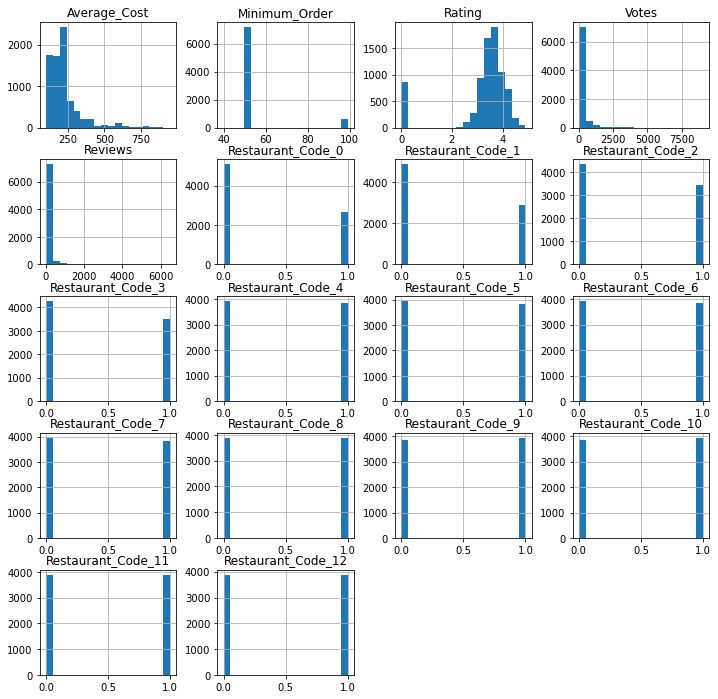

In [21]:
x_b.hist(bins=18, figsize=(12,12))
plt.show()

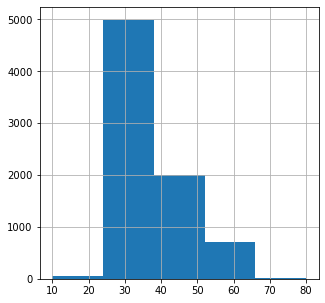

In [22]:
y_e.hist(bins=5 ,figsize=(5,5))
plt.show()

In [23]:
xWinsorizer = Winsorizer( capping_method = 'iqr',
            tail = 'both',
            fold = 1.5
            ,variables = ['Average_Cost', 'Minimum_Order','Rating', 'Votes', 'Reviews'])

yWinsorizer = Winsorizer( capping_method = 'iqr',
            tail = 'right',
            fold = 1.5
            ,variables = 'Delivery_Time')

In [24]:
x_wo = xWinsorizer.fit_transform(x_b)
y_wo = yWinsorizer.fit_transform(y_e.to_frame())

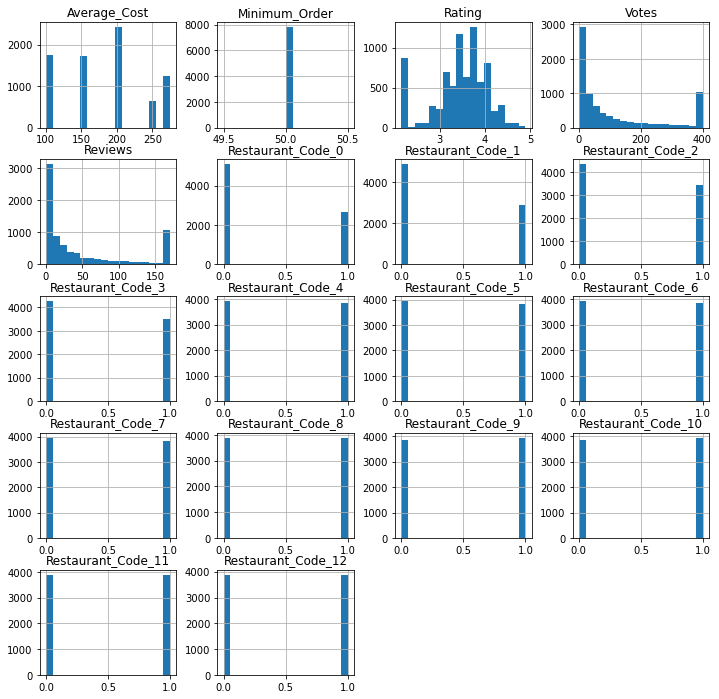

In [25]:
x_wo.hist(bins=18, figsize=(12,12))
plt.show()

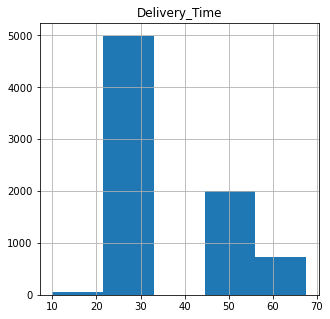

In [26]:
y_wo.hist(bins=5,figsize=(5,5))
plt.show()

<AxesSubplot:>

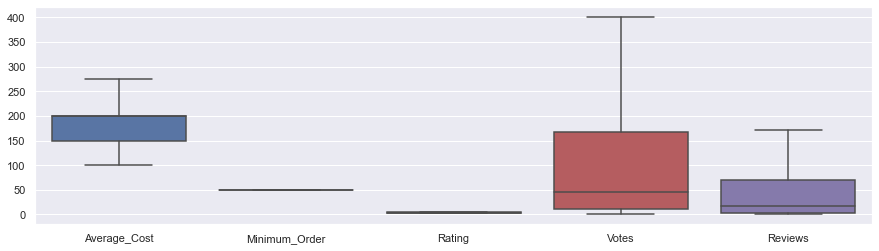

In [27]:
import seaborn as sns; sns.set_theme()
sns.set(rc = {'figure.figsize':(15,4)})
sns.boxplot(data = x_wo[['Average_Cost', 'Minimum_Order','Rating', 'Votes', 'Reviews']] )

In [28]:
#Check if there are any nulls
x_wo.isnull().values.any()

False

In [29]:
from sklearn.ensemble import AdaBoostRegressor

seed = 123

In [30]:
abr = AdaBoostRegressor(n_estimators = 500, random_state = seed)

model_abr = etr.fit(x_wo,y_wo.Delivery_Time)

In [31]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_abr = cross_val_score(abr ,x_wo ,y_wo ,cv = 10, n_jobs = -1, scoring = metric)

In [32]:
#Metric results

print('Decision Tree Regressor RMSE:',np.absolute(kfold_dtr.mean()))

print('Bagged Decision Tree Regressor RMSE:',np.absolute(kfold_bdtr.mean()))

print('Random Forest RMSE:',np.absolute(kfold_rfr.mean()))

print('Extra Trees RMSE:',np.absolute(kfold_etr.mean()))

print('Adaboost RMSE:',np.absolute(kfold_abr.mean()))

print('Average Delivery Time', y_e.mean())

Decision Tree Regressor RMSE: 14.483706499340173
Bagged Decision Tree Regressor RMSE: 10.08080889993642
Random Forest RMSE: 10.05831852514086
Extra Trees RMSE: 10.006464084286314
Adaboost RMSE: 10.98613282901783
Average Delivery Time 36.99408131755018


### Stochastic Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

seed = 123

In [34]:
gbr = GradientBoostingRegressor(n_estimators = 500, max_features = 'log2',random_state = seed)

model_gbr = gbr.fit(x_b,y_e)

In [35]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_gbr = cross_val_score(gbr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [36]:
#Metric results

print('Decision Tree Regressor RMSE:',np.absolute(kfold_dtr.mean()))

print('Bagged Decision Tree Regressor RMSE:',np.absolute(kfold_bdtr.mean()))

print('Random Forest RMSE:',np.absolute(kfold_rfr.mean()))

print('Extra Trees RMSE:',np.absolute(kfold_etr.mean()))

print('Adaboost RMSE:',np.absolute(kfold_abr.mean()))

print('Gradient Boost RMSE:',np.absolute(kfold_gbr.mean()))

print('Average Delivery Time', y_e.mean())

Decision Tree Regressor RMSE: 14.483706499340173
Bagged Decision Tree Regressor RMSE: 10.08080889993642
Random Forest RMSE: 10.05831852514086
Extra Trees RMSE: 10.006464084286314
Adaboost RMSE: 10.98613282901783
Gradient Boost RMSE: 9.928151146094898
Average Delivery Time 36.99408131755018


### XGBoost

In [37]:
from xgboost import XGBRegressor, plot_importance

seed = 123

In [38]:
XGBr = XGBRegressor(random_state = seed)

model_XGBr = XGBr.fit(x_b ,y_e)

In [39]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_XGBr = cross_val_score(XGBr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [40]:
#Validation

print('XGB RMSE:',np.absolute(kfold_XGBr.mean()))

XGB RMSE: 10.445831240484889


#### Tuning XGBoost

In [41]:
n_trees = range(50, 500, 50)

max_depth = range(1,4)

In [42]:
params_to_search = dict(n_estimators = n_trees, max_depth = max_depth)

In [43]:
# Grid Search
from sklearn import model_selection

grid_search = model_selection.GridSearchCV(XGBr,params_to_search
                                           , scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 10)

In [44]:
grid_results = grid_search.fit(x_b ,y_e)

In [45]:
grid_results.best_params_

{'max_depth': 2, 'n_estimators': 50}

In [46]:
np.absolute(grid_results.cv_results_['mean_test_score'])

array([ 9.90210071,  9.8817455 ,  9.87785723,  9.87324794,  9.87212466,
        9.87236166,  9.87136434,  9.87131788,  9.8719465 ,  9.8632115 ,
        9.88791932,  9.90589931,  9.94156729,  9.97002254, 10.00987026,
       10.03398434, 10.04395168, 10.07123108,  9.90059148,  9.96869628,
       10.04149006, 10.10705422, 10.1555051 , 10.23009971, 10.28579977,
       10.32835068, 10.37756399])

In [47]:
grid_results.cv_results_['params']

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 150},
 {'max_depth': 1, 'n_estimators': 200},
 {'max_depth': 1, 'n_estimators': 250},
 {'max_depth': 1, 'n_estimators': 300},
 {'max_depth': 1, 'n_estimators': 350},
 {'max_depth': 1, 'n_estimators': 400},
 {'max_depth': 1, 'n_estimators': 450},
 {'max_depth': 2, 'n_estimators': 50},
 {'max_depth': 2, 'n_estimators': 100},
 {'max_depth': 2, 'n_estimators': 150},
 {'max_depth': 2, 'n_estimators': 200},
 {'max_depth': 2, 'n_estimators': 250},
 {'max_depth': 2, 'n_estimators': 300},
 {'max_depth': 2, 'n_estimators': 350},
 {'max_depth': 2, 'n_estimators': 400},
 {'max_depth': 2, 'n_estimators': 450},
 {'max_depth': 3, 'n_estimators': 50},
 {'max_depth': 3, 'n_estimators': 100},
 {'max_depth': 3, 'n_estimators': 150},
 {'max_depth': 3, 'n_estimators': 200},
 {'max_depth': 3, 'n_estimators': 250},
 {'max_depth': 3, 'n_estimators': 300},
 {'max_depth': 3, 'n_estimators': 350},
 {'

In [70]:
# Finding best learning rate

learn_rate = [0.0001,0.001,0.01,0.1,0.2,0.3]

In [71]:
params_to_search = dict(learning_rate = learn_rate)

In [72]:
grid_search = model_selection.GridSearchCV(XGBr,params_to_search
                                           , scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 10)

In [73]:
grid_resutls = grid_search.fit(x_b,y_e)

In [76]:
grid_resutls.best_params_

{'learning_rate': 0.2}

In [98]:
# set up mdel again with new parasm

n_trees = 50

max_depth = 2

learning_rate = 0.2

XGBr = XGBRegressor(max_depth = max_depth, n_estimators = n_trees, learning_rate = 0.2,  random_state = seed)

model_XGBr = XGBr.fit(x_b ,y_e)

In [99]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_XGBr = cross_val_score(XGBr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [100]:
#Validation reults

print('XGB RMSE:',np.absolute(kfold_XGBr.mean()))

XGB RMSE: 9.855789043835788


#### XGBoost Feature Importance

In [53]:
from numpy import sort

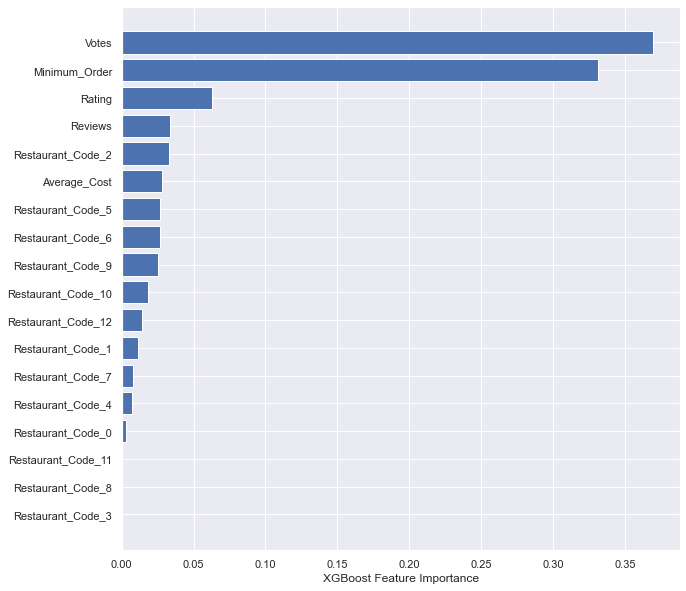

In [54]:
sorted_idx = model_XGBr.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(x_b.columns[sorted_idx], model_XGBr.feature_importances_[sorted_idx])
plt.xlabel('XGBoost Feature Importance')
plt.show()

In [101]:
from sklearn.feature_selection import SelectFromModel

for i in model_XGBr.feature_importances_[sorted_idx]:
    selected_model = SelectFromModel(model_XGBr, threshold = i, prefit = True)
    selected_x = selected_model.transform(x_b)
    selected_r = XGBRegressor(random_state = seed)
    selected_r.fit(selected_x, y_e)
    kfold = cross_val_score(XGBr ,selected_x ,y_e ,cv = 10, n_jobs = -1, scoring = metric)
    print('{} {}'.format(i,np.absolute(kfold.mean())))

0.0 9.855789043835788
0.0 9.855789043835788
0.0 9.855789043835788
0.0035650974605232477 9.849531895102288
0.008373976685106754 9.849959733567376
0.021294277161359787 9.84887228847188
0.011763088405132294 9.852731431049433
0.0 9.855789043835788
0.017665347084403038 9.84660339561075
0.014073937200009823 9.847727858858637
0.02501719817519188 9.848314700564437
0.0 9.855789043835788
0.03583849221467972 9.847096667271796
0.037729449570178986 9.862837287825903
0.03134171664714813 9.848314700564437
0.06350350379943848 9.860842848888074
0.30487513542175293 9.99500863288829
0.42495882511138916 10.190506831585745


The first 10 features in order of importance, give the best rmse (9.8490).

### Voting

In [56]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor, VotingRegressor
#from sklearn.tree import DecisionTreeRegressor

seed = 123

In [102]:
gbr = GradientBoostingRegressor(n_estimators = 500, max_features = 'log2',random_state = seed)

rfr = RandomForestRegressor(n_estimators = 500, random_state = seed, max_features = 'log2')

XGBr = XGBRegressor(max_depth = max_depth, n_estimators = n_trees, learning_rate = 0.2,  random_state = seed)

vr = VotingRegressor([('gradboost',gbr),('ranforest',rfr),('XGBoost',XGBr)])

In [103]:
results_r = []
models_r = [gbr,rfr,XGBr,vr]


for r in models_r:
    result = r.fit(x_e,y_e)
    result_kfold = cross_val_score(r, x_b, y_e, cv = 10,n_jobs = -1, scoring = metric)
    results_r.append(result_kfold )

In [104]:
#fit voting model

model_vr = vr.fit(x_b,y_e)

#Validation

metric = 'neg_root_mean_squared_error'

kfold_vr = cross_val_score(vr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [105]:
for i, rr in enumerate(results_r):
    print(models_r[i],np.absolute(rr.mean()))

GradientBoostingRegressor(max_features='log2', n_estimators=500,
                          random_state=123) 9.928151146094898
RandomForestRegressor(max_features='log2', n_estimators=500, random_state=123) 9.82879320903814
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 9.855789043835788
VotingRegressor(estimators=[('gradboost',
                             GradientBoostingRegressor(max_features='log2',
                   

### Stacking

In [61]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

seed = 123

In [107]:
gbr = GradientBoostingRegressor(n_estimators = 500, max_features = 'log2',random_state = seed)

rfr = RandomForestRegressor(n_estimators = 500, random_state = seed, max_features = 'log2')

XGBr = XGBRegressor(max_depth = max_depth, n_estimators = n_trees, learning_rate = 0.2,  random_state = seed)

lr = Lasso(alpha=.9)

sr = StackingRegressor(regressors = [gbr, rfr, XGBr], meta_regressor = lr)

In [108]:
results_r = []
models_r = [gbr,rfr,XGBr, sr]

metric = 'neg_root_mean_squared_error'

for r in models_r:
    result = r.fit(x_b,y_e)
    result_kfold = cross_val_score(r, x_b, y_e, cv = 10,n_jobs = -1, scoring = metric)
    results_r.append(result_kfold )

In [109]:
#fit stacked models

model_sr = sr.fit(x_e,y_e)

#Validation

kfold_sr = cross_val_score(sr ,x_b ,y_e ,cv = 10, n_jobs = -1, scoring = metric)

In [110]:
for i, rr in enumerate(results_r):
    print(models_r[i],np.absolute(rr.mean()))

GradientBoostingRegressor(max_features='log2', n_estimators=500,
                          random_state=123) 9.928151146094898
RandomForestRegressor(max_features='log2', n_estimators=500, random_state=123) 9.82879320903814
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 9.855789043835788
StackingRegressor(meta_regressor=Lasso(alpha=0.9),
                  regressors=[GradientBoostingRegressor(max_features='log2',
         

## Predictions

In [111]:
def predict(Average_Cost, Minimum_Order, Rating, Votes, Reviews, Restaurant_Code):
    
    x_df = x_e
    
    numpy_data = np.array([[Average_Cost, Minimum_Order, Rating, Votes, Reviews, Restaurant_Code]])
    n_d = pd.DataFrame(data=numpy_data, columns=[ 'Average_Cost', 'Minimum_Order'
                                                 ,'Rating','Votes', 'Reviews','Restaurant_Code'])
    
    df = x_df.append(n_d, ignore_index = True)
    
    encoder = ce.BinaryEncoder(cols=['Restaurant_Code'])

    df = encoder.fit_transform(df)
    
    pred = df.iloc[len(df)-1].values.reshape(1,-1)
       
    prediction = model_vr.predict(pred) 
    
    return print('Estimated Delivery Time:',prediction[0])

In [112]:
# Inputs: (Average_Cost, Minimum_Order, Rating, Votes, Reviews, Restaurant_Code)

predict(200,99,3.2,521,235, 4376)

Estimated Delivery Time: 53.62676005600482
